In [1]:
#We'll be using TF 2.1 and torchaudio
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14922600040131919082
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18040966673772112448
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1973416187436871791
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7843663053
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2184066527601288203
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [3]:
# Hyperparameters

hop = 192  # hop size (window size = 6*hop)
sr = 16000  # sampling rate
min_level_db = -100  # reference values to normalize data
ref_level_db = 20

shape = 24  # length of time axis of split specrograms to feed to generator
vec_len = 128  # length of vector generated by siamese vector
bs = 16  # batch size
delta = 2.0  # constant for siamese loss

In [4]:
# There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
# For waveform reconstruction, a gradient-based method is used:

""" Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56."""

# ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type("torch.cuda.FloatTensor")

specobj = Spectrogram(
    n_fft=6 * hop, win_length=6 * hop, hop_length=hop, pad=0, power=2, normalized=True
)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.0)
melfunc = melobj.forward


def melspecfunc(waveform):
    specgram = specfunc(waveform)
    mel_specgram = melfunc(specgram)
    return mel_specgram


def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())


def GRAD(
    spec,
    transform_fn,
    samples=None,
    init_x0=None,
    maxiter=1000,
    tol=1e-6,
    verbose=1,
    evaiter=10,
    lr=0.003,
):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1] * hop) - hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1, samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict["spectral_convergence"] = 0
    metric = "spectral_convergence"

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr * 0.9999
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()


def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db) * 2.0) - 1.0, -1, 1)


def denormalize(S):
    return (((np.clip(S, -1, 1) + 1.0) / 2.0) * -min_level_db) + min_level_db


def prep(wv, hop=192):
    S = np.array(
        torch.squeeze(melspecfunc(torch.Tensor(wv).view(1, -1))).detach().cpu()
    )
    S = librosa.power_to_db(S) - ref_level_db
    return normalize(S)


def deprep(S):
    S = denormalize(S) + ref_level_db
    S = librosa.db_to_power(S)
    wv = GRAD(np.expand_dims(S, 0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
    return np.array(np.squeeze(wv))

In [5]:
# Helper functions

# Generate spectrograms from waveform array
def tospec(data):
    specs = np.empty(data.shape[0], dtype=object)
    for i in range(data.shape[0]):
        x = data[i]
        S = prep(x)
        S = np.array(S, dtype=np.float32)
        specs[i] = np.expand_dims(S, -1)
    print(specs.shape)
    return specs


# Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4 * 16000):
    x, sr = librosa.load(path, sr=16000)
    x, _ = librosa.effects.trim(x)
    loudls = librosa.effects.split(x, top_db=50)
    xls = np.array([])
    for interv in loudls:
        xls = np.concatenate((xls, x[interv[0] : interv[1]]))
    x = xls
    num = x.shape[0] // length
    specs = np.empty(num, dtype=object)
    for i in range(num - 1):
        a = x[i * length : (i + 1) * length]
        S = prep(a)
        S = np.array(S, dtype=np.float32)
        try:
            sh = S.shape
            specs[i] = S
        except AttributeError:
            print("spectrogram failed")
    print(specs.shape)
    return specs


# Waveform array from path of folder containing wav files
def audio_array(path):
    ls = glob(f"{path}/*.wav")
    adata = []
    for i in range(len(ls)):
        x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
        x = np.array(x, dtype=np.float32)
        adata.append(x)
    return np.array(adata)


# Concatenate spectrograms in array along the time axis
def testass(a):
    but = False
    con = np.array([])
    nim = a.shape[0]
    for i in range(nim):
        im = a[i]
        im = np.squeeze(im)
        if not but:
            con = im
            but = True
        else:
            con = np.concatenate((con, im), axis=1)
    return np.squeeze(con)


# Split spectrograms in chunks with equal size
def splitcut(data):
    ls = []
    mini = 0
    minifinal = 10 * shape  # max spectrogram length
    for i in range(data.shape[0] - 1):
        if data[i].shape[1] <= data[i + 1].shape[1]:
            mini = data[i].shape[1]
        else:
            mini = data[i + 1].shape[1]
        if mini >= 3 * shape and mini < minifinal:
            minifinal = mini
    for i in range(data.shape[0]):
        x = data[i]
        if x.shape[1] >= 3 * shape:
            for n in range(x.shape[1] // minifinal):
                ls.append(x[:, n * minifinal : n * minifinal + minifinal, :])
            ls.append(x[:, -minifinal:, :])
    return np.array(ls)

In [6]:
# Tim: Make source/target folders. I will go for some soundfiles for two different instruments (keyboard and brass)

from mlp64 import data
from mlp64 import experiment
from mlp64 import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("/home/tim/Desktop/MLP64/dataset/nsynth-test/")
first = data.create_dataset_df(path / "examples.json", instrument=327, exclude_qualities=["distortion", "percussive"], velocity=[75, 75])
second = data.create_dataset_df(path / "examples.json", instrument=414, exclude_qualities=["distortion", "percussive"], velocity=[75, 75])

JSON loaded into DataFrame!
JSON loaded into DataFrame!


In [7]:
fds = data.NSynth(path / "audio", first, n=3, target_field="instrument")
sds = data.NSynth(path / "audio", second, n=3, target_field="instrument")

In [8]:
# uncomment to generate files

# n_files = range(10)
# for j in n_files:
#     i = np.random.choice(range(len(fds)))
#     sf.write("../baselines/melganvc/a2/" + str(j) + ".wav", fds.__getitem__(i)[0].cpu().numpy(), samplerate=16000)
    
# for j in n_files:
#     i = np.random.choice(range(len(sds)))
#     sf.write("../baselines/melganvc/b2/" + str(j) + ".wav", sds.__getitem__(i)[0].cpu().numpy(), samplerate=16000)

In [9]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms

# Keyboard
awv = audio_array('../baselines/melganvc/a2')                               #get waveform array from folder containing wav files
aspec = tospec(awv)                                                                 #get spectrogram array
adata = splitcut(aspec)                                                             #split spectrogams to fixed length
# Brass
bwv = audio_array('../baselines/melganvc/b2')
bspec = tospec(bwv)
bdata = splitcut(bspec)

(10,)
(10,)


In [10]:
# Creating Tensorflow Datasets

@tf.function
def proc(x):
    return tf.image.random_crop(x, size=[hop, 3 * shape, 1])


dsa = (
    tf.data.Dataset.from_tensor_slices(adata)
    .repeat(50)
    .map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(10000)
    .batch(bs, drop_remainder=True)
)
dsb = (
    tf.data.Dataset.from_tensor_slices(bdata)
    .repeat(50)
    .map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(10000)
    .batch(bs, drop_remainder=True)
)

In [11]:
# Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape


def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):
    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations

    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == "channels_first":
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(
            self.name + "_u",
            shape=tuple([1, self.kernel.shape.as_list()[-1]]),
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False,
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))

        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W / sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == "channels_first":
                outputs = tf.nn.bias_add(outputs, self.bias, data_format="NCHW")
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format="NHWC")
        if self.activation is not None:
            return self.activation(outputs)

        return outputs


class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):
    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations

    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == "channels_first":
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(
            self.name + "_u",
            shape=tuple([1, self.kernel.shape.as_list()[-1]]),
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False,
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))

        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W / sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == "channels_first":
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(
            height,
            kernel_h,
            padding=self.padding,
            output_padding=out_pad_h,
            stride=stride_h,
            dilation=self.dilation_rate[0],
        )
        out_width = conv_utils.deconv_output_length(
            width,
            kernel_w,
            padding=self.padding,
            output_padding=out_pad_w,
            stride=stride_w,
            dilation=self.dilation_rate[1],
        )
        if self.data_format == "channels_first":
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate,
        )

        if not context.executing_eagerly():
            out_shape = self.compute_output_shape(inputs.shape)
            outputs.set_shape(out_shape)

        if self.use_bias:
            outputs = tf.nn.bias_add(
                outputs,
                self.bias,
                data_format=conv_utils.convert_data_format(self.data_format, ndim=4),
            )

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(
            self.name + "_u",
            shape=tuple([1, self.kernel.shape.as_list()[-1]]),
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False,
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W / sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)
        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
            outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
            if not context.executing_eagerly():
                shape = inputs.shape.as_list()
                output_shape = shape[:-1] + [self.units]
                outputs.set_shape(output_shape)
        else:
            inputs = math_ops.cast(inputs, self._compute_dtype)
            if K.is_sparse(inputs):
                outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
            else:
                outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [12]:
# Networks Architecture

init = tf.keras.initializers.he_uniform()


def conv2d(
    layer_input,
    filters,
    kernel_size=4,
    strides=2,
    padding="same",
    leaky=True,
    bnorm=True,
    sn=True,
):
    if leaky:
        Activ = LeakyReLU(alpha=0.2)
    else:
        Activ = ReLU()
    if sn:
        d = ConvSN2D(
            filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=init,
            use_bias=False,
        )(layer_input)
    else:
        d = Conv2D(
            filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=init,
            use_bias=False,
        )(layer_input)
    if bnorm:
        d = BatchNormalization()(d)
    d = Activ(d)
    return d


def deconv2d(
    layer_input,
    layer_res,
    filters,
    kernel_size=4,
    conc=True,
    scalev=False,
    bnorm=True,
    up=True,
    padding="same",
    strides=2,
):
    if up:
        u = UpSampling2D((1, 2))(layer_input)
        u = ConvSN2D(
            filters,
            kernel_size,
            strides=(1, 1),
            kernel_initializer=init,
            use_bias=False,
            padding=padding,
        )(u)
    else:
        u = ConvSN2DTranspose(
            filters,
            kernel_size,
            strides=strides,
            kernel_initializer=init,
            use_bias=False,
            padding=padding,
        )(layer_input)
    if bnorm:
        u = BatchNormalization()(u)
    u = LeakyReLU(alpha=0.2)(u)
    if conc:
        u = Concatenate()([u, layer_res])
    return u


# Extract function: splitting spectrograms
def extract_image(im):
    im1 = Cropping2D(((0, 0), (0, 2 * (im.shape[2] // 3))))(im)
    im2 = Cropping2D(((0, 0), (im.shape[2] // 3, im.shape[2] // 3)))(im)
    im3 = Cropping2D(((0, 0), (2 * (im.shape[2] // 3), 0)))(im)
    return im1, im2, im3


# Assemble function: concatenating spectrograms
def assemble_image(lsim):
    im1, im2, im3 = lsim
    imh = Concatenate(2)([im1, im2, im3])
    return imh


# U-NET style architecture
def build_generator(input_shape):
    h, w, c = input_shape
    inp = Input(shape=input_shape)
    # downscaling
    g0 = tf.keras.layers.ZeroPadding2D((0, 1))(inp)
    g1 = conv2d(g0, 256, kernel_size=(h, 3), strides=1, padding="valid")
    g2 = conv2d(g1, 256, kernel_size=(1, 9), strides=(1, 2))
    g3 = conv2d(g2, 256, kernel_size=(1, 7), strides=(1, 2))
    # upscaling
    g4 = deconv2d(g3, g2, 256, kernel_size=(1, 7), strides=(1, 2))
    g5 = deconv2d(g4, g1, 256, kernel_size=(1, 9), strides=(1, 2), bnorm=False)
    g6 = ConvSN2DTranspose(
        1,
        kernel_size=(h, 1),
        strides=(1, 1),
        kernel_initializer=init,
        padding="valid",
        activation="tanh",
    )(g5)
    return Model(inp, g6, name="G")


# Siamese Network
def build_siamese(input_shape):
    h, w, c = input_shape
    inp = Input(shape=input_shape)
    g1 = conv2d(inp, 256, kernel_size=(h, 3), strides=1, padding="valid", sn=False)
    g2 = conv2d(g1, 256, kernel_size=(1, 9), strides=(1, 2), sn=False)
    g3 = conv2d(g2, 256, kernel_size=(1, 7), strides=(1, 2), sn=False)
    g4 = Flatten()(g3)
    g5 = Dense(vec_len)(g4)
    return Model(inp, g5, name="S")


# Discriminator (Critic) Network
def build_critic(input_shape):
    h, w, c = input_shape
    inp = Input(shape=input_shape)
    g1 = conv2d(inp, 512, kernel_size=(h, 3), strides=1, padding="valid", bnorm=False)
    g2 = conv2d(g1, 512, kernel_size=(1, 9), strides=(1, 2), bnorm=False)
    g3 = conv2d(g2, 512, kernel_size=(1, 7), strides=(1, 2), bnorm=False)
    g4 = Flatten()(g3)
    g4 = DenseSN(1, kernel_initializer=init)(g4)
    return Model(inp, g4, name="C")

In [23]:
# Load past models from path to resume training or test
def load(path):
    gen = build_generator((hop, shape, 1))
    siam = build_siamese((hop, shape, 1))
    critic = build_critic((hop, 3 * shape, 1))
    gen.load_weights(path + "/gen.h5")
    critic.load_weights(path + "/critic.h5")
    siam.load_weights(path + "/siam.h5")
    return gen, critic, siam


# Build models
def build():
    gen = build_generator((hop, shape, 1))
    siam = build_siamese((hop, shape, 1))
    critic = build_critic(
        (hop, 3 * shape, 1)
    )  # the discriminator accepts as input spectrograms of triple the width of those generated by the generator
    return gen, critic, siam


# Generate a random batch to display current training results
def testgena():
    sw = True
    while sw:
        a = np.random.choice(aspec)
        if a.shape[1] // shape != 1:
            sw = False
    dsa = []
    if a.shape[1] // shape > 6:
        num = 6
    else:
        num = a.shape[1] // shape
    rn = np.random.randint(a.shape[1] - (num * shape))
    for i in range(num):
        im = a[:, rn + (i * shape) : rn + (i * shape) + shape]
        im = np.reshape(im, (im.shape[0], im.shape[1], 1))
        dsa.append(im)
    return np.array(dsa, dtype=np.float32)


# Show results mid-training
def save_test_image_full(path):
    a = testgena()
    print(a.shape)
    ab = gen(a, training=False)
    ab = testass(ab)
    a = testass(a)
    abwv = deprep(ab)
    awv = deprep(a)
    sf.write(path + "/new_file.wav", abwv, sr)
    IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
    IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis("off")
    axs[0].set_title("Source")
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis("off")
    axs[1].set_title("Generated")
    plt.show()


# Save in training loop
def save_end(
    epoch, gloss, closs, mloss, n_save=3, save_path="../content/"
):  # use custom save_path (i.e. Drive '../content/drive/My Drive/')
    if epoch % n_save == 0:
        print("Saving...")
        path = (
            f"{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}"
        )
        os.mkdir(path)
        gen.save_weights(path + "/gen.h5")
        critic.save_weights(path + "/critic.h5")
        siam.save_weights(path + "/siam.h5")
        save_test_image_full(path)

In [24]:
# Losses


def mae(x, y):
    return tf.reduce_mean(tf.abs(x - y))


def mse(x, y):
    return tf.reduce_mean((x - y) ** 2)


def loss_travel(sa, sab, sa1, sab1):
    l1 = tf.reduce_mean(((sa - sa1) - (sab - sab1)) ** 2)
    l2 = tf.reduce_mean(
        tf.reduce_sum(
            -(
                tf.nn.l2_normalize(sa - sa1, axis=[-1])
                * tf.nn.l2_normalize(sab - sab1, axis=[-1])
            ),
            axis=-1,
        )
    )
    return l1 + l2


def loss_siamese(sa, sa1):
    logits = tf.sqrt(tf.reduce_sum((sa - sa1) ** 2, axis=-1, keepdims=True))
    return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))


def d_loss_f(fake):
    return tf.reduce_mean(tf.maximum(1 + fake, 0))


def d_loss_r(real):
    return tf.reduce_mean(tf.maximum(1 - real, 0))


def g_loss_f(fake):
    return tf.reduce_mean(-fake)

In [25]:
# Get models and optimizers
def get_networks(shape, load_model=False, path=None):
    if not load_model:
        gen, critic, siam = build()
    else:
        gen, critic, siam = load(path)
    print("Built networks")

    opt_gen = Adam(0.0001, 0.5)
    opt_disc = Adam(0.0001, 0.5)

    return gen, critic, siam, [opt_gen, opt_disc]


# Set learning rate
def update_lr(lr):
    opt_gen.learning_rate = lr
    opt_disc.learning_rate = lr

In [26]:
# Training Functions

# Train Generator, Siamese and Critic
@tf.function
def train_all(a, b):
    # splitting spectrogram in 3 parts
    aa, aa2, aa3 = extract_image(a)
    bb, bb2, bb3 = extract_image(b)

    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

        # translating A to B
        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        # identity mapping B to B - COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
#         fid = gen(bb, training=True)
#         fid2 = gen(bb2, training=True)
#         fid3 = gen(bb3, training=True)
        # concatenate/assemble converted spectrograms
        fabtot = assemble_image([fab, fab2, fab3])

        # feed concatenated spectrograms to critic
        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)
        # feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
        sab = siam(fab, training=True)
        sab2 = siam(fab3, training=True)
        sa = siam(aa, training=True)
        sa2 = siam(aa3, training=True)

        # identity mapping loss
#         loss_id = (
#             mae(bb, fid) + mae(bb2, fid2) + mae(bb3, fid3)
#         ) / 3.0
        loss_id = 0. # IF THE IDENTITY LOSS TERM IS NOT NEEDED
        # travel loss
        loss_m = loss_travel(sa, sab, sa2, sab2) + loss_siamese(sa, sa2)
        # generator and critic losses
        loss_g = g_loss_f(cab)
        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)
        loss_d = (loss_dr + loss_df) / 2.0
        # generator+siamese total loss
        lossgtot = (
            loss_g + 10.0 * loss_m #+ 0.5 * loss_id
        )  # CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)

    # computing and applying gradients
    grad_gen = tape_gen.gradient(
        lossgtot, gen.trainable_variables + siam.trainable_variables
    )
    opt_gen.apply_gradients(
        zip(grad_gen, gen.trainable_variables + siam.trainable_variables)
    )

    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr, loss_df, loss_g, loss_id


# Train Critic only
@tf.function
def train_d(a, b):
    aa, aa2, aa3 = extract_image(a)
    with tf.GradientTape() as tape_disc:

        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        fabtot = assemble_image([fab, fab2, fab3])

        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)

        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)

        loss_d = (loss_dr + loss_df) / 2.0

    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr, loss_df

In [27]:
# Training Loop


def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5, save_path="../baselines/melganvc/check"):

    update_lr(lr)
    df_list = []
    dr_list = []
    g_list = []
    id_list = []
    c = 0
    g = 0

    for epoch in range(epochs):
        bef = time.time()

        for batchi, (a, b) in enumerate(zip(dsa, dsb)):

            if batchi % gupt == 0:
                dloss_t, dloss_f, gloss, idloss = train_all(a, b)
            else:
                dloss_t, dloss_f = train_d(a, b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi % 600 == 0:
                print(
                    f"[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ",
                    end="",
                )
                print(f"r: {np.mean(dr_list[-g:], axis=0)}] ", end="")
                print(f"[G loss: {np.mean(g_list[-g:], axis=0)}] ", end="")
                print(f"[ID loss: {np.mean(id_list[-g:])}] ", end="")
                print(f"[LR: {lr}]")
                g = 0
            nbatch = batchi

        print(f"Time/Batch {(time.time()-bef)/nbatch}")
        save_end(
            epoch,
            np.mean(g_list[-n_save * c :], axis=0),
            np.mean(df_list[-n_save * c :], axis=0),
            np.mean(id_list[-n_save * c :], axis=0),
            n_save=n_save,
            save_path=save_path
        )
        print(
            f"Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}"
        )
        c = 0

In [28]:
# Build models and initialize optimizers

# If load_model=True, specify the path where the models are saved

gen, critic, siam, [opt_gen, opt_disc] = get_networks(
    shape, load_model=True, path="../baselines/melganvc/check/MELGANVC-1.1043108-0.1492001-0.0/"
)

Built networks


[Epoch 0/1000] [Batch 0] [D loss f: 0.0 r: 0.21023783087730408] [G loss: 1.7587050199508667] [ID loss: 0.0] [LR: 0.0002]


  3%|▎         | 60/2000 [00:00<00:02, 783.01it/s, loss=0.14, spectral_convergence=-.33]   

Time/Batch 0.07171507343169181
Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:02<00:00, 855.44it/s, loss=0.000318, spectral_convergence=-31.9]


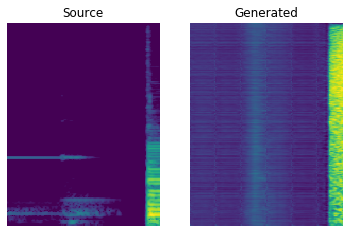

Mean D loss: 0.07322345674037933 Mean G loss: 1.3354315757751465 Mean ID loss: 0.0
[Epoch 1/1000] [Batch 0] [D loss f: 0.07365299016237259 r: 0.11462085694074631] [G loss: 1.3334161043167114] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02518931204272855
Mean D loss: 0.07624716311693192 Mean G loss: 1.3012561798095703 Mean ID loss: 0.0
[Epoch 2/1000] [Batch 0] [D loss f: 0.07612963020801544 r: 0.10293935239315033] [G loss: 1.3002521991729736] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02505003406155494
Mean D loss: 0.08554506301879883 Mean G loss: 1.362871527671814 Mean ID loss: 0.0
[Epoch 3/1000] [Batch 0] [D loss f: 0.08578086644411087 r: 0.11732753366231918] [G loss: 1.3624619245529175] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025063645455145066
Mean D loss: 0.06905780732631683 Mean G loss: 1.312546730041504 Mean ID loss: 0.0
[Epoch 4/1000] [Batch 0] [D loss f: 0.06872930377721786 r: 0.1062045469880104] [G loss: 1.313578486442566] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02504509341332220

  5%|▌         | 100/2000 [00:00<00:02, 876.73it/s, loss=0.0233, spectral_convergence=-7.54]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:02<00:00, 860.88it/s, loss=3.04e-6, spectral_convergence=-25.2]


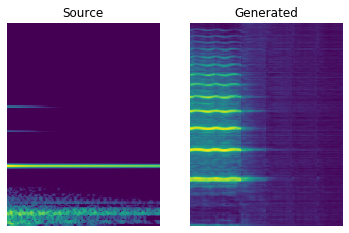

Mean D loss: 0.09670320153236389 Mean G loss: 1.3212306499481201 Mean ID loss: 0.0
[Epoch 101/1000] [Batch 0] [D loss f: 0.09511931985616684 r: 0.1410461962223053] [G loss: 1.3236634731292725] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.0255263005533526
Mean D loss: 0.09098228067159653 Mean G loss: 1.3025280237197876 Mean ID loss: 0.0
[Epoch 102/1000] [Batch 0] [D loss f: 0.09134116768836975 r: 0.15012428164482117] [G loss: 1.302411437034607] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025513941241848852
Mean D loss: 0.09590449929237366 Mean G loss: 1.334370732307434 Mean ID loss: 0.0
[Epoch 103/1000] [Batch 0] [D loss f: 0.09577934443950653 r: 0.15540984272956848] [G loss: 1.3349781036376953] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025409487755067888
Mean D loss: 0.07766102254390717 Mean G loss: 1.330333948135376 Mean ID loss: 0.0
[Epoch 104/1000] [Batch 0] [D loss f: 0.07812809199094772 r: 0.12806811928749084] [G loss: 1.3293967247009277] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025509434

  5%|▌         | 100/2000 [00:00<00:02, 863.30it/s, loss=0.038, spectral_convergence=-7.53]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:02<00:00, 867.78it/s, loss=5.44e-5, spectral_convergence=-18.1]


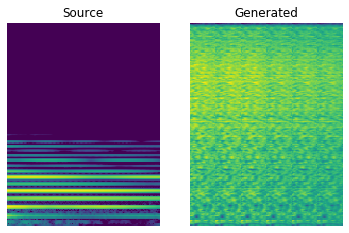

Mean D loss: 0.12046488374471664 Mean G loss: 1.2680931091308594 Mean ID loss: 0.0
[Epoch 201/1000] [Batch 0] [D loss f: 0.11982639133930206 r: 0.1717892438173294] [G loss: 1.2672419548034668] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025599230489423197
Mean D loss: 0.1081869900226593 Mean G loss: 1.1906200647354126 Mean ID loss: 0.0
[Epoch 202/1000] [Batch 0] [D loss f: 0.10774772614240646 r: 0.1596507877111435] [G loss: 1.1931122541427612] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02545370747966151
Mean D loss: 0.11342750489711761 Mean G loss: 1.2397964000701904 Mean ID loss: 0.0
[Epoch 203/1000] [Batch 0] [D loss f: 0.1144176721572876 r: 0.1626601368188858] [G loss: 1.2368463277816772] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025370008714737432
Mean D loss: 0.1215045154094696 Mean G loss: 1.180649757385254 Mean ID loss: 0.0
[Epoch 204/1000] [Batch 0] [D loss f: 0.1209072694182396 r: 0.1844426691532135] [G loss: 1.1819491386413574] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.0255527973175

  5%|▌         | 100/2000 [00:00<00:02, 863.45it/s, loss=0.0225, spectral_convergence=-5.21]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:02<00:00, 851.62it/s, loss=5.13e-5, spectral_convergence=-42.6] 


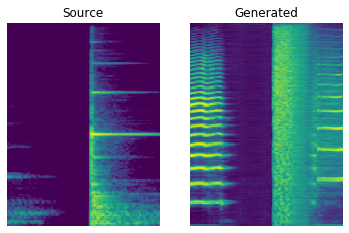

Mean D loss: 0.07964295893907547 Mean G loss: 1.2947663068771362 Mean ID loss: 0.0
[Epoch 301/1000] [Batch 0] [D loss f: 0.07967954128980637 r: 0.14062103629112244] [G loss: 1.295088529586792] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02541521595370385
Mean D loss: 0.07429157942533493 Mean G loss: 1.2474480867385864 Mean ID loss: 0.0
[Epoch 302/1000] [Batch 0] [D loss f: 0.07351236790418625 r: 0.13154591619968414] [G loss: 1.2492653131484985] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02551165396167386
Mean D loss: 0.08944795280694962 Mean G loss: 1.2010821104049683 Mean ID loss: 0.0
[Epoch 303/1000] [Batch 0] [D loss f: 0.09019311517477036 r: 0.1403617113828659] [G loss: 1.1985645294189453] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025315756951608967
Mean D loss: 0.08868437260389328 Mean G loss: 1.1933830976486206 Mean ID loss: 0.0
[Epoch 304/1000] [Batch 0] [D loss f: 0.08788669854402542 r: 0.14262062311172485] [G loss: 1.1942218542099] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.0254549918

  5%|▌         | 100/2000 [00:00<00:02, 905.16it/s, loss=0.152, spectral_convergence=-4.23]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:02<00:00, 868.86it/s, loss=0.00227, spectral_convergence=-28.5]


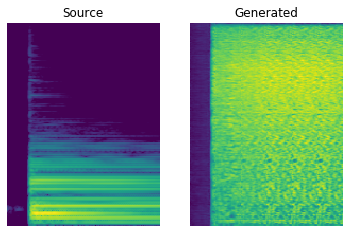

Mean D loss: 0.07745124399662018 Mean G loss: 1.22231125831604 Mean ID loss: 0.0
[Epoch 401/1000] [Batch 0] [D loss f: 0.0766904428601265 r: 0.15159204602241516] [G loss: 1.2240973711013794] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.025472634838473413
Mean D loss: 0.08404573798179626 Mean G loss: 1.1776243448257446 Mean ID loss: 0.0
[Epoch 402/1000] [Batch 0] [D loss f: 0.08410221338272095 r: 0.1608380377292633] [G loss: 1.1786309480667114] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02541396079524871
Mean D loss: 0.08329025655984879 Mean G loss: 1.23269784450531 Mean ID loss: 0.0
[Epoch 403/1000] [Batch 0] [D loss f: 0.08324240893125534 r: 0.15669146180152893] [G loss: 1.2327196598052979] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.02538640422205771
Mean D loss: 0.07317587733268738 Mean G loss: 1.2736151218414307 Mean ID loss: 0.0
[Epoch 404/1000] [Batch 0] [D loss f: 0.07305827736854553 r: 0.1599712073802948] [G loss: 1.275418758392334] [ID loss: 0.0] [LR: 0.0002]
Time/Batch 0.0255128122145

KeyboardInterrupt: 

In [29]:
# Training

# n_save = how many epochs between each saving and displaying of results
# gupt = how many discriminator updates for generator+siamese update

train(1000, batch_size=bs, lr=0.0002, n_save=100, gupt=3, save_path="../baselines/melganvc/check")

In [ ]:
# After Training, use these functions to convert data with the generator and save the results

# Assembling generated Spectrogram chunks into final Spectrogram
def specass(a, spec):
    but = False
    con = np.array([])
    nim = a.shape[0]
    for i in range(nim - 1):
        im = a[i]
        im = np.squeeze(im)
        if not but:
            con = im
            but = True
        else:
            con = np.concatenate((con, im), axis=1)
    diff = spec.shape[1] - (nim * shape)
    a = np.squeeze(a)
    con = np.concatenate((con, a[-1, :, -diff:]), axis=1)
    return np.squeeze(con)


# Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
    dsa = []
    for i in range(spec.shape[1] // shape):
        im = spec[:, i * shape : i * shape + shape]
        im = np.reshape(im, (im.shape[0], im.shape[1], 1))
        dsa.append(im)
    imlast = spec[:, -shape:]
    imlast = np.reshape(imlast, (imlast.shape[0], imlast.shape[1], 1))
    dsa.append(imlast)
    return np.array(dsa, dtype=np.float32)


# Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path="../baselines/melganvc/check", show=False):
    specarr = chopspec(spec)
    print(specarr.shape)
    a = specarr
    print("Generating...")
    ab = gen(a, training=False)
    print("Assembling and Converting...")
    a = specass(a, spec)
    ab = specass(ab, spec)
    awv = deprep(a)
    abwv = deprep(ab)
    print("Saving...")
    pathfin = f"{path}/{name}"
    os.mkdir(pathfin)
    sf.write(pathfin + "/AB.wav", abwv, sr)
    sf.write(pathfin + "/A.wav", awv, sr)
    print("Saved WAV!")
    IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
    IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
    if show:
        fig, axs = plt.subplots(ncols=2)
        axs[0].imshow(np.flip(a, -2), cmap=None)
        axs[0].axis("off")
        axs[0].set_title("Source")
        axs[1].imshow(np.flip(ab, -2), cmap=None)
        axs[1].axis("off")
        axs[1].set_title("Generated")
        plt.show()
    return abwv

In [ ]:
# Wav to wav conversion

wv, sr = librosa.load(librosa.util.example_audio_file(), sr=16000)  # Load waveform
print(wv.shape)
speca = prep(wv)  # Waveform to Spectrogram

plt.figure(figsize=(50, 1))  # Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis("off")
plt.show()

abwv = towave(speca, name="FILENAME1", path="../baselines/melganvc/check")  # Convert and save wav